In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/adhd_dataset')

In [ ]:
!pip install pandasql==0.7.1
!pip install mne
!pip install pymatreader

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.1-py3-none-any.whl size=26963 sha256=5209072bce687a72550e6fff59041b52a4065ed8ccaf5d1a453c8c616c4e47ba
  Stored in directory: /root/.cache/pip/wheels/f9/99/51/eee415a4428c5bd6048b8d685be7bdc385b7530100812918ce
Successfully built pandasql
  Attempting uninstall: pandasql
    Found existing installation: pandasql 0.7.3
    Uninstalling pandasql-0.7.3:
      Successfully uninstalled pandasql-0.7.3


In [ ]:
import scipy,mne
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import mne
import io
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,
    Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import pandasql as ps



from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

#from test_utils import summary, comparator
#import public_tests

%matplotlib inline

#RGB Representation
##ADHD Data

In [ ]:
import glob
files=[]
for name in glob.glob('/content/drive/MyDrive/adhd_dataset/ADHD_part1/*.set'):
    files.append(name)
for name in glob.glob('/content/drive/MyDrive/adhd_dataset/ADHD_part2/*.set'):
    files.append(name)

In [ ]:
# set frequency Bands
frequencies=np.arange(4, 40, 2)

In [ ]:
# read dataset and seperate person and segment
genereted_images=list()
person=0
segment_variable = 0
condition = 0
segment=[]
Z=[]
con = 20
for i in files:
    person += 1
    raw=mne.io.read_raw_eeglab(i)
    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False,overlap=1.5)
    power = mne.time_frequency.tfr_morlet(epochs, n_cycles=5, return_itc=False,
                                      freqs=frequencies, average = False, n_jobs=-1)

    theta=power.to_data_frame()[(4 <= power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 8)].drop(columns=["condition"])

    alpha=power.to_data_frame()[(8 < power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 12)].drop(columns=["condition"])

    beta_gamma=power.to_data_frame()[(12 < power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 40)].drop(columns=["condition"])

    theta=theta.groupby(["epoch","time"]).agg("mean")
    alpha=alpha.groupby(["epoch","time"]).agg("mean")
    beta_gamma=beta_gamma.groupby(["epoch","time"]).agg("mean")
    for j in range(np.max(theta.reset_index().epoch)+1):
        red=np.array(theta.loc[j].drop(columns=["freq"]).T)
        green=np.array(alpha.loc[j].drop(columns=["freq"]).T)
        blue=np.array(beta_gamma.loc[j].drop(columns=["freq"]).T)
        image=np.concatenate((red[:, :, np.newaxis],green[:, :, np.newaxis],blue[:, :, np.newaxis]),axis=2)
        Z.append(person)
        image=(image-np.min(image))/(np.max(image)-np.min(image))
        genereted_images.append(image)
        segment.append(segment_variable)
        condition += 1
        if condition >= con:
            segment_variable += 1
            condition = 0
        if condition <= con and j == np.max(theta.reset_index().epoch):
            segment_variable += 1
            condition = 0

Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v1p.fdt
Not setting metadata
188 matching events found
No baseline correction applied
0 projection items activated
Loading data for 188 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.1s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v3p.fdt
Not setting metadata
521 matching events found
No baseline correction applied
0 projection items activated
Loading data for 521 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   13.4s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v6p.fdt
Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Loading data for 271 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v8p.fdt
Not setting metadata
243 matching events found
No baseline correction applied
0 projection items activated
Loading data for 243 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v10p.fdt
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Loading data for 220 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v12p.fdt
Not setting metadata
272 matching events found
No baseline correction applied
0 projection items activated
Loading data for 272 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v14p.fdt
Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Loading data for 271 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.4s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v15p.fdt
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Loading data for 672 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   13.4s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v18p.fdt
Not setting metadata
387 matching events found
No baseline correction applied
0 projection items activated
Loading data for 387 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    8.1s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v19p.fdt
Not setting metadata
357 matching events found
No baseline correction applied
0 projection items activated
Loading data for 357 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.9s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v20p.fdt
Not setting metadata
549 matching events found
No baseline correction applied
0 projection items activated
Loading data for 549 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    8.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v21p.fdt
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Loading data for 255 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v22p.fdt
Not setting metadata
186 matching events found
No baseline correction applied
0 projection items activated
Loading data for 186 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.1s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v24p.fdt
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Loading data for 253 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v25p.fdt
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Loading data for 151 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v27p.fdt
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Loading data for 448 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v28p.fdt
Not setting metadata
428 matching events found
No baseline correction applied
0 projection items activated
Loading data for 428 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v29p.fdt
Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
Loading data for 375 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v30p.fdt
Not setting metadata
335 matching events found
No baseline correction applied
0 projection items activated
Loading data for 335 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.9s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v31p.fdt
Not setting metadata
179 matching events found
No baseline correction applied
0 projection items activated
Loading data for 179 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v32p.fdt
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Loading data for 279 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v33p.fdt
Not setting metadata
453 matching events found
No baseline correction applied
0 projection items activated
Loading data for 453 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v34p.fdt
Not setting metadata
302 matching events found
No baseline correction applied
0 projection items activated
Loading data for 302 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.9s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v35p.fdt
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Loading data for 236 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v36p.fdt
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Loading data for 268 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v37p.fdt
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Loading data for 142 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v38p.fdt
Not setting metadata
382 matching events found
No baseline correction applied
0 projection items activated
Loading data for 382 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.9s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v39p.fdt
Not setting metadata
281 matching events found
No baseline correction applied
0 projection items activated
Loading data for 281 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v40p.fdt
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part1/v173p.fdt
Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
Loading data for 375 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v177p.fdt
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 257 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.4s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v179p.fdt
Not setting metadata
195 matching events found
No baseline correction applied
0 projection items activated
Loading data for 195 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v181p.fdt
Not setting metadata
163 matching events found
No baseline correction applied
0 projection items activated
Loading data for 163 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v183p.fdt
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Loading data for 287 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v190p.fdt
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Loading data for 238 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v196p.fdt
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Loading data for 206 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v198p.fdt
Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
Loading data for 303 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.9s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v200p.fdt
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
Loading data for 196 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v204p.fdt
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Loading data for 316 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v206p.fdt
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.1s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v209p.fdt
Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
Loading data for 470 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    8.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v213p.fdt
Not setting metadata
190 matching events found
No baseline correction applied
0 projection items activated
Loading data for 190 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v215p.fdt
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
Loading data for 330 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v219p.fdt
Not setting metadata
421 matching events found
No baseline correction applied
0 projection items activated
Loading data for 421 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v227p.fdt
Not setting metadata
435 matching events found
No baseline correction applied
0 projection items activated
Loading data for 435 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    8.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v231p.fdt
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Loading data for 305 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v234p.fdt
Not setting metadata
531 matching events found
No baseline correction applied
0 projection items activated
Loading data for 531 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v236p.fdt
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Loading data for 207 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v238p.fdt
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v244p.fdt
Not setting metadata
606 matching events found
No baseline correction applied
0 projection items activated
Loading data for 606 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   10.0s finished


Not setting metadata
Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v246p.fdt
Not setting metadata
329 matching events found
No baseline correction applied
0 projection items activated
Loading data for 329 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.5s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v250p.fdt
Not setting metadata
213 matching events found
No baseline correction applied
0 projection items activated
Loading data for 213 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v254p.fdt
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Loading data for 160 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v263p.fdt
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v265p.fdt
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated
Loading data for 284 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.8s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v270p.fdt
Not setting metadata
367 matching events found
No baseline correction applied
0 projection items activated
Loading data for 367 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v274p.fdt
Not setting metadata
267 matching events found
No baseline correction applied
0 projection items activated
Loading data for 267 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v279p.fdt
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v284p.fdt
Not setting metadata
237 matching events found
No baseline correction applied
0 projection items activated
Loading data for 237 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.0s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v286p.fdt
Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
Loading data for 176 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.7s finished


Reading /content/drive/MyDrive/adhd_dataset/ADHD_part2/v288p.fdt
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.7s finished


In [ ]:
Y=np.repeat(1,len(genereted_images))

##Control Dataset

In [ ]:
import glob
files=[]
for name in glob.glob('/content/drive/MyDrive/adhd_dataset/Control_part1/*.set'):
    files.append(name)
for name in glob.glob('/content/drive/MyDrive/adhd_dataset/Control_part2/*.set'):
    files.append(name)

In [ ]:
for i in files:
    person += 1
    raw=mne.io.read_raw_eeglab(i)
    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False,overlap=1.5)
    power = mne.time_frequency.tfr_morlet(epochs, n_cycles=5, return_itc=False,
                                      freqs=frequencies, average = False, n_jobs=-1)

    theta=power.to_data_frame()[(4 <= power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 8)].drop(columns=["condition"])

    alpha=power.to_data_frame()[(8 < power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 12)].drop(columns=["condition"])

    beta_gamma=power.to_data_frame()[(12 < power.to_data_frame()["freq"]) & (power.to_data_frame()["freq"]  <= 40)].drop(columns=["condition"])

    theta=theta.groupby(["epoch","time"]).agg("mean")
    alpha=alpha.groupby(["epoch","time"]).agg("mean")
    beta_gamma=beta_gamma.groupby(["epoch","time"]).agg("mean")
    print(person)
    for j in range(np.max(theta.reset_index().epoch)+1):
        red=np.array(theta.loc[j].drop(columns=["freq"]).T)
        green=np.array(alpha.loc[j].drop(columns=["freq"]).T)
        blue=np.array(beta_gamma.loc[j].drop(columns=["freq"]).T)
        image=np.concatenate((red[:, :, np.newaxis],green[:, :, np.newaxis],blue[:, :, np.newaxis]),axis=2)
        Z.append(person)
        image=(image-np.min(image))/(np.max(image)-np.min(image))
        genereted_images.append(image)
        segment.append(segment_variable)
        condition += 1
        if condition >= con:
            segment_variable += 1
            condition = 0
        if condition <= con and j == np.max(theta.reset_index().epoch):
            segment_variable += 1
            condition = 0

Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v41p.fdt
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Loading data for 192 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished


62
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v42p.fdt
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.0s finished


63
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v43p.fdt
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
Loading data for 196 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.5s finished


64
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v44p.fdt
Not setting metadata
175 matching events found
No baseline correction applied
0 projection items activated
Loading data for 175 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


65
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v45p.fdt
Not setting metadata
166 matching events found
No baseline correction applied
0 projection items activated
Loading data for 166 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.1s finished


66
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v46p.fdt
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.9s finished


67
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v47p.fdt
Not setting metadata
166 matching events found
No baseline correction applied
0 projection items activated
Loading data for 166 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


68
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v48p.fdt
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Loading data for 160 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.1s finished


69
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v49p.fdt
Not setting metadata
259 matching events found
No baseline correction applied
0 projection items activated
Loading data for 259 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


70
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v50p.fdt
Not setting metadata
250 matching events found
No baseline correction applied
0 projection items activated
Loading data for 250 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.8s finished


71
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v51p.fdt
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Loading data for 121 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.5s finished


72
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v52p.fdt
Not setting metadata
213 matching events found
No baseline correction applied
0 projection items activated
Loading data for 213 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.0s finished


73
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v53p.fdt
Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
Loading data for 295 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.3s finished


74
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v54p.fdt
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.8s finished


75
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v55p.fdt
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Loading data for 220 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


76
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v56p.fdt
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
Loading data for 217 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.4s finished


77
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v57p.fdt
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Loading data for 226 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.0s finished


78
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v58p.fdt
Not setting metadata
214 matching events found
No baseline correction applied
0 projection items activated
Loading data for 214 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


79
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v59p.fdt
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Loading data for 255 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.8s finished


80
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v60p.fdt
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Loading data for 199 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished


81
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v107p.fdt
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Loading data for 306 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.2s finished


82
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v108p.fdt
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Loading data for 294 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.8s finished


83
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v109p.fdt
Not setting metadata
247 matching events found
No baseline correction applied
0 projection items activated
Loading data for 247 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


84
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v110p.fdt
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Loading data for 255 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.3s finished


85
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v111p.fdt
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Loading data for 236 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


86
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v112p.fdt
Not setting metadata
246 matching events found
No baseline correction applied
0 projection items activated
Loading data for 246 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


87
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v113p.fdt
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.9s finished


88
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v114p.fdt
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
Loading data for 204 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished


89
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v115p.fdt
Not setting metadata
241 matching events found
No baseline correction applied
0 projection items activated
Loading data for 241 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.1s finished


90
Reading /content/drive/MyDrive/adhd_dataset/Control_part1/v116p.fdt
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Loading data for 298 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.8s finished


91
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v117.fdt
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
Loading data for 397 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.6s finished


92
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v118.fdt
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Loading data for 184 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.8s finished


93
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v120.fdt
Not setting metadata
185 matching events found
No baseline correction applied
0 projection items activated
Loading data for 185 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.4s finished


94
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v121.fdt
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
Loading data for 252 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


95
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v123.fdt
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Loading data for 224 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.9s finished


96
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v125.fdt
Not setting metadata
237 matching events found
No baseline correction applied
0 projection items activated
Loading data for 237 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.1s finished


97
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v127.fdt
Not setting metadata
227 matching events found
No baseline correction applied
0 projection items activated
Loading data for 227 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.7s finished


98
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v129.fdt
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Loading data for 172 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.2s finished


99
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v131.fdt
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 257 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.5s finished


100
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v133.fdt
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Loading data for 232 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.0s finished


101
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v134.fdt
Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
Loading data for 205 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


102
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v138.fdt
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Loading data for 192 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.2s finished


103
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v140.fdt
Not setting metadata
265 matching events found
No baseline correction applied
0 projection items activated
Loading data for 265 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.4s finished


104
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v143.fdt
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.9s finished


105
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v147.fdt
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Loading data for 219 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.8s finished


106
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v149.fdt
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Loading data for 264 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.5s finished


107
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v151.fdt
Not setting metadata
323 matching events found
No baseline correction applied
0 projection items activated
Loading data for 323 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.2s finished


108
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v297.fdt
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Loading data for 211 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.3s finished


109
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v298.fdt
Not setting metadata
274 matching events found
No baseline correction applied
0 projection items activated
Loading data for 274 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


110
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v299.fdt
Not setting metadata
344 matching events found
No baseline correction applied
0 projection items activated
Loading data for 344 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.4s finished


111
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v300.fdt
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Loading data for 403 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    6.9s finished


112
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v302.fdt
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Loading data for 275 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.5s finished


113
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v303.fdt
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.6s finished


114
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v304.fdt
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Loading data for 206 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.7s finished


115
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v305.fdt
Not setting metadata
345 matching events found
No baseline correction applied
0 projection items activated
Loading data for 345 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.3s finished


116
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v306.fdt
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Loading data for 282 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    7.6s finished


Not setting metadata
117
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v307.fdt
Not setting metadata
353 matching events found
No baseline correction applied
0 projection items activated
Loading data for 353 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.5s finished


118
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v308.fdt
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated
Loading data for 263 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.4s finished


119
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v309.fdt
Not setting metadata
384 matching events found
No baseline correction applied
0 projection items activated
Loading data for 384 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.0s finished


120
Reading /content/drive/MyDrive/adhd_dataset/Control_part2/v310.fdt
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
Loading data for 275 events and 256 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s


Not setting metadata


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.6s finished


121


In [ ]:
# build Y and dataset
genereted_images=np.stack(genereted_images)
Y=np.concatenate((Y,np.repeat(0,genereted_images.shape[0]-len(Y))))
full_data =pd.DataFrame({"Y":Y,"person":Z,"segment":segment})
full_data

,Y,person,segment
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0
...,...,...,...
33429,0,121,1733
33430,0,121,1733
33431,0,121,1733
33432,0,121,1733


In [ ]:
print(len(full_data[full_data.Y == 1]))
print(len(full_data[full_data.Y == 0]))

18651
14783


In [ ]:
#check dimention of data
assert len(Y)==genereted_images.shape[0],"your data have problem"
print(len(Y),genereted_images.shape)

33434 (33434, 19, 256, 3)


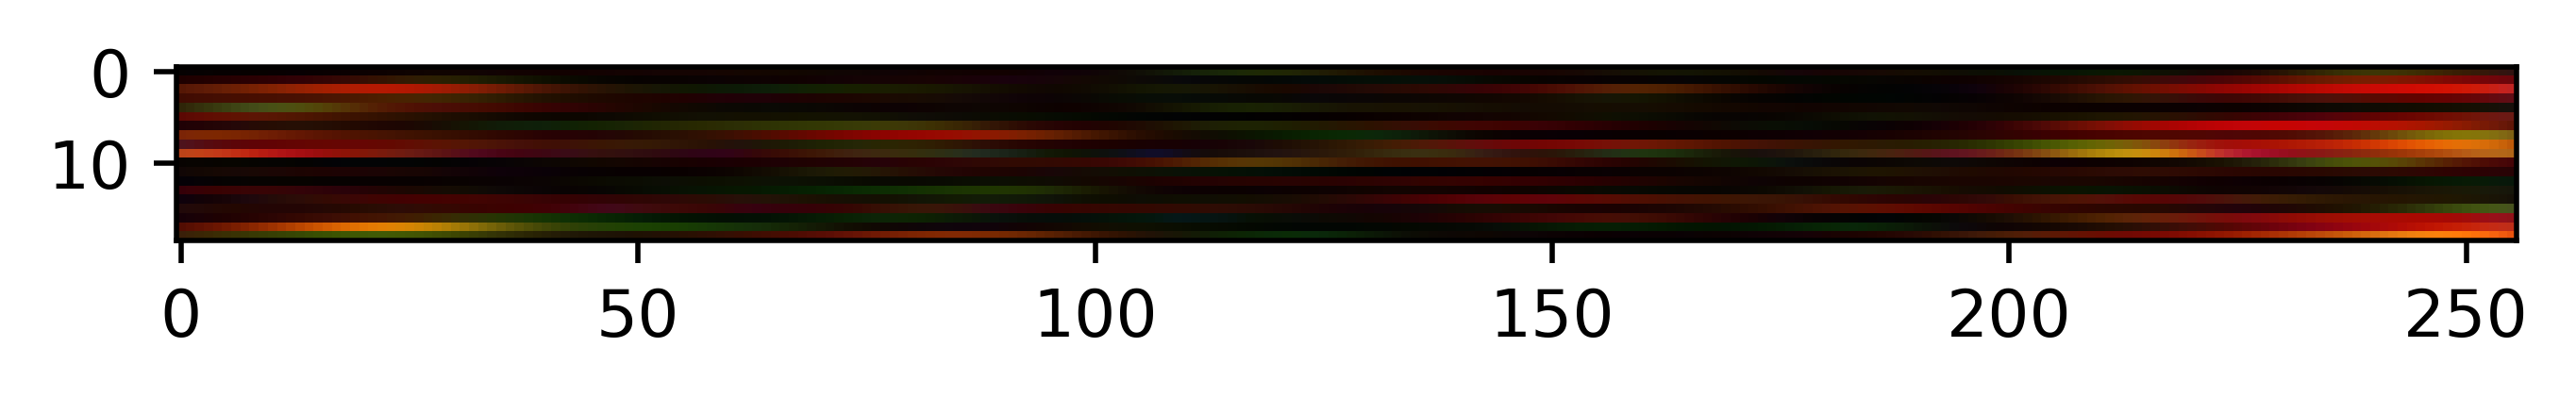

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
plt.imshow(genereted_images[25145])
plt.show()

#Model Building
## A CNN with Dropout

In [ ]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def CNN_model_1(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    initializer = tf.keras.initializers.HeNormal()
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (3, 3), strides = (1, 1),padding="same", kernel_initializer = initializer)(X_input)
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    X = Conv2D(64, (3, 3), strides = (1, 1),padding="valid", kernel_initializer = initializer)(X)
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    X = Conv2D(128, (2, 2), strides = (1, 1),padding="valid", kernel_initializer = initializer)(X)
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    # output layer
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_initializer = initializer)(X)
    X= Dropout(rate=0.25)(X)

    X = Dense(classes, activation='sigmoid', kernel_initializer = initializer)(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

## ResNet

In [ ]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    #X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    #X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    #X =  BatchNormalization(axis = 3)(X, training = training)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [ ]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X =  BatchNormalization(axis = 3)(X, training=training)

    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut =  Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut =  BatchNormalization(axis = 3)(X_shortcut, training=training)

    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### customized resnet

In [ ]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def CNN_model_2(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    initializer = tf.keras.initializers.HeNormal()
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (3, 3), strides = (1, 1),padding="same", kernel_initializer = initializer)(X_input)
    X = identity_block(X, 3, [32, 32, 32])
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    X = Conv2D(64, (3, 3), strides = (1, 1),padding="valid", kernel_initializer = initializer)(X)
    X = identity_block(X, 3, [64, 64, 64])
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    X = Conv2D(128, (2, 2), strides = (1, 1),padding="valid", kernel_initializer = initializer)(X)
    X = identity_block(X, 3, [128, 128, 128])
    #X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    X= Dropout(rate=0.25)(X)

    # output layer
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_initializer = initializer)(X)
    X= Dropout(rate=0.25)(X)

    X = Dense(classes, activation='sigmoid', kernel_initializer = initializer)(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# subject base from scratch

In [ ]:
# partial
partials = ps.sqldf("""
            select segment from full_data
            group by segment
            having count(Y)<{}
            """.format(con))

compelete_segment = ps.sqldf("""
            select segment,0 as dummy_y from full_data
            group by segment
            having count(Y)>={}
            """.format(con))

In [ ]:
# choose train test from k-fold

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=10)
train, test = list(kfold.split(compelete_segment.segment,compelete_segment.dummy_y))[5]
list(kfold.split(compelete_segment.segment,compelete_segment.dummy_y))[0]

(array([   1,    2,    3, ..., 1610, 1611, 1612]),
 array([   0,    4,   15,   23,   33,   38,   46,   51,   52,   54,   58,
          61,   64,   96,   97,  100,  114,  130,  137,  145,  147,  154,
         163,  190,  191,  210,  221,  236,  240,  246,  247,  252,  256,
         257,  269,  276,  280,  312,  316,  329,  351,  372,  375,  411,
         421,  431,  433,  443,  444,  448,  476,  483,  490,  510,  512,
         520,  533,  541,  553,  555,  585,  595,  596,  599,  612,  623,
         639,  650,  664,  707,  714,  723,  726,  730,  741,  749,  760,
         772,  781,  784,  795,  801,  806,  810,  812,  817,  840,  848,
         871,  876,  880,  894,  912,  915,  952,  964,  973,  974,  980,
         999, 1005, 1012, 1014, 1015, 1070, 1110, 1116, 1118, 1124, 1132,
        1151, 1155, 1167, 1171, 1172, 1180, 1190, 1194, 1204, 1211, 1214,
        1217, 1223, 1231, 1234, 1239, 1246, 1257, 1264, 1269, 1281, 1292,
        1294, 1301, 1303, 1316, 1361, 1375, 1388, 1393, 1395,

In [ ]:
train = compelete_segment.segment.loc[train]
test = compelete_segment.segment.loc[test]
scores_ResNet={"accuracy":[],"precision":[],"recall":[],"f1":[],"confusion_matrix":[]}

In [ ]:
# bulild train and test

Y_train = full_data.Y[full_data.segment.isin(list(train)+list(partials.segment))]
train_index = full_data.reset_index()["index"][full_data.segment.isin(list(train)+list(partials.segment))]
X_train = genereted_images[train_index]

Y_test = full_data.Y[full_data.segment.isin(test)]
test_index = full_data.reset_index()["index"][full_data.segment.isin(test)]
X_test = genereted_images[test_index]

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

## fit the model

In [ ]:
model_ResNet = CNN_model_2(input_shape = (19, 256,3), classes = 2)
model_ResNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
X_train, Y_train = shuffle(X_train, Y_train)
# Fit the model
model_ResNet.fit(X_train, convert_to_one_hot(Y_train,2).T, epochs = 100, batch_size = 128,validation_split=0.1,callbacks=[callback])

Epoch 1/100
213/213 [==============================] - 700s 3s/step - loss: 0.6157 - accuracy: 0.6679 - val_loss: 0.5673 - val_accuracy: 0.7105
Epoch 2/100
213/213 [==============================] - 700s 3s/step - loss: 0.4959 - accuracy: 0.7550 - val_loss: 0.4177 - val_accuracy: 0.8041
Epoch 3/100
213/213 [==============================] - 698s 3s/step - loss: 0.4062 - accuracy: 0.8122 - val_loss: 0.3443 - val_accuracy: 0.8458
Epoch 4/100
213/213 [==============================] - 703s 3s/step - loss: 0.3328 - accuracy: 0.8508 - val_loss: 0.3067 - val_accuracy: 0.8680
Epoch 5/100
213/213 [==============================] - 699s 3s/step - loss: 0.2928 - accuracy: 0.8743 - val_loss: 0.3233 - val_accuracy: 0.8508
Epoch 6/100
213/213 [==============================] - 699s 3s/step - loss: 0.2509 - accuracy: 0.8926 - val_loss: 0.2484 - val_accuracy: 0.8928
Epoch 7/100
213/213 [==============================] - 700s 3s/step - loss: 0.2230 - accuracy: 0.9069 - val_loss: 0.2033 - val_accuracy:

### evaluation

In [ ]:
# accuracy on images

preds = model_ResNet.evaluate(X_test, convert_to_one_hot(Y_test,2).T)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
# accuracy on segment based

Y_data = full_data[["segment","Y"]][full_data.segment.isin(test)]
Y_data["y_pred"] = model_ResNet.predict(X_test).argmax(axis=1)
Y_data = Y_data.groupby("segment").agg([lambda x:x.value_counts().index[0]]).reset_index()
Y_data.columns = ["segment","Y","y_pred"]
# evaluate the model
scores_ResNet["accuracy"].append(metrics.accuracy_score(Y_data.Y,Y_data.y_pred))
scores_ResNet["confusion_matrix"].append(metrics.confusion_matrix(Y_data.Y,Y_data.y_pred))
scores_ResNet["recall"].append(metrics.recall_score(Y_data.Y,Y_data.y_pred))
scores_ResNet["precision"].append(metrics.precision_score(Y_data.Y,Y_data.y_pred))
scores_ResNet["f1"].append(metrics.f1_score(Y_data.Y,Y_data.y_pred))

In [ ]:
scores_ResNet

# Cross Validation for Segment based

In [ ]:
scores_CNN={"accuracy":[],"precision":[],"recall":[],"f1":[],"confusion_matrix":[]}

In [ ]:
# partial
partials = ps.sqldf("""
            select segment from full_data
            group by segment
            having count(Y)<{}
            """.format(con))

compelete_segment = ps.sqldf("""
            select segment,0 as dummy_y from full_data
            group by segment
            having count(Y)>={}
            """.format(con))

In [ ]:

# fix random seed for reproducibility

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=10)


for train, test in kfold.split(compelete_segment.segment,compelete_segment.dummy_y):
  train = compelete_segment.segment.loc[train]
  test = compelete_segment.segment.loc[test]
  Y_train = full_data.Y[full_data.segment.isin(list(train)+list(partials.segment))]
  train_index = full_data.reset_index()["index"][full_data.segment.isin(list(train)+list(partials.segment))]
  X_train = genereted_images[train_index]

  Y_test = full_data.Y[full_data.segment.isin(test)]
  test_index = full_data.reset_index()["index"][full_data.segment.isin(test)]
  X_test = genereted_images[test_index]

  Y_train = np.array(Y_train)
  Y_test = np.array(Y_test)
	# create model
	# Compile model
  model_ResNet = CNN_model_2(input_shape = (19, 256,3), classes = 2)
  model_ResNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
  X_train, Y_train = shuffle(X_train, Y_train)
  # Fit the model
  model_ResNet.fit(X_train, convert_to_one_hot(Y_train,2).T, epochs = 100, batch_size = 128,validation_split=0.1,callbacks=[callback])
	print("Next Model ------------------------------------------------------------------------------------------------")
  Y_data = full_data[["segment","Y"]][full_data.segment.isin(test)]
  Y_data["y_pred"] = model_ResNet.predict(X_test).argmax(axis=1)
  Y_data = Y_data.groupby("segment").agg([lambda x:x.value_counts().index[0]]).reset_index()
  Y_data.columns = ["segment","Y","y_pred"]
  # evaluate the model
  scores_ResNet["accuracy"].append(metrics.accuracy_score(Y_data.Y,Y_data.y_pred))
  scores_ResNet["confusion_matrix"].append(metrics.confusion_matrix(Y_data.Y,Y_data.y_pred))
  scores_ResNet["recall"].append(metrics.recall_score(Y_data.Y,Y_data.y_pred))
  scores_ResNet["precision"].append(metrics.precision_score(Y_data.Y,Y_data.y_pred))
  scores_ResNet["f1"].append(metrics.f1_score(Y_data.Y,Y_data.y_pred))